<a href="https://colab.research.google.com/github/BraydenAC/510-HIPA-AI/blob/main/HIPAAI_Trained_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modeling the distribution of the data:

Label distribution:
Label
No     51
Yes    49
Name: count, dtype: int64


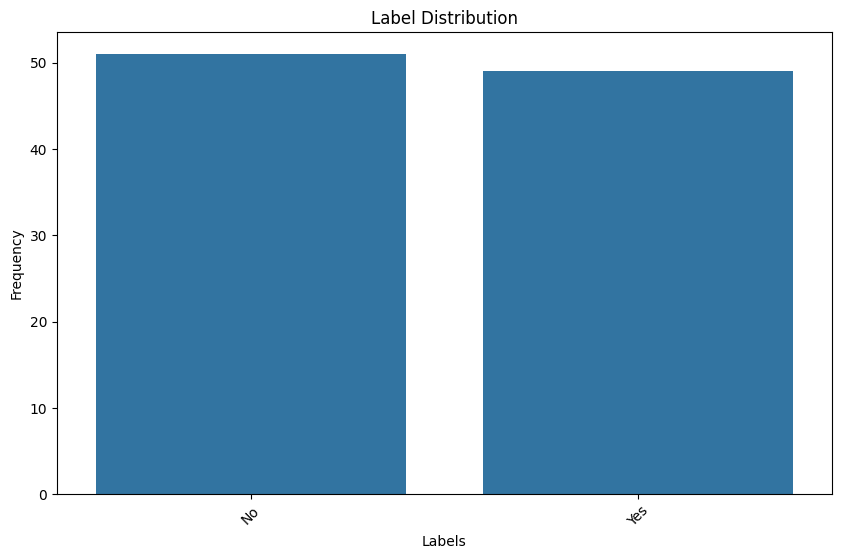

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV
csv_file = '/content/Compiled Annotations Distribution.csv'
data = pd.read_csv(csv_file, encoding='ISO-8859-1')

label_column = 'Label'

# Calculate the distribution of labels
label_counts = data[label_column].value_counts()

# Print the distribution
print("Label distribution:")
print(label_counts)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x=label_column, order=label_counts.index)
plt.title("Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()



Imports:

In [3]:
# Import libraries
import torch
from transformers import AutoTokenizer, AutoModel
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score

Load the CSV and use BERT to tokenize text:

In [4]:
# Load the csv with proper encoding
df = pd.read_csv('/content/Compiled Annotations CSV.csv', encoding='ISO-8859-1')

# Extract texts and labels
texts = df['Features'].tolist()
labels = df['Label'].tolist()

# Load BERT
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Set the model to evaluation mode
model.eval()

# Tokenize and encode the text inputs
inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='pt')

# Pass the inputs through the BERT model
with torch.no_grad():
    outputs = model(**inputs)

# Extract the sentence embeddings
sentence_embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # shape: [batch_size, hidden_state_size]

# Save embeddings to avoid recomputation
pd.DataFrame(sentence_embeddings).to_csv('sentence_embeddings.csv', index=False)
pd.DataFrame(labels, columns=['Label']).to_csv('labels.csv', index=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Split data and logistic regression:

In [5]:
# Load embeddings and labels
embeddings = pd.read_csv('sentence_embeddings.csv').values
labels = pd.read_csv('labels.csv').values.ravel()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.3, random_state=42)

# Train the logistic regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Test set prediction and classification report:

In [6]:
# Make predictions
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision, recall, f1 score
precision = precision_score(y_test, y_pred, pos_label='Yes')
recall = recall_score(y_test, y_pred, pos_label='Yes')
f1 = f1_score(y_test, y_pred, pos_label='Yes')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Detailed classification report
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))


Accuracy: 0.63
Precision: 0.62
Recall: 0.57
F1 Score: 0.59
              precision    recall  f1-score   support

          No       0.65      0.69      0.67        16
         Yes       0.62      0.57      0.59        14

    accuracy                           0.63        30
   macro avg       0.63      0.63      0.63        30
weighted avg       0.63      0.63      0.63        30



Cross validation analysis:

In [7]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print(f'Cross-validated accuracy: {scores.mean():.2f}')


Cross-validated accuracy: 0.59
